In [1]:
!pip install lalsuite pyfstat optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

gcs_bucket = 'gravity-proj'
colab_folder = 'new'

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!mkdir {colab_folder}
!gcsfuse --implicit-dirs {gcs_bucket} {colab_folder}

Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2426  100  2426    0     0  69314      0 --:--:-- --:--:-- --:--:-- 69314
OK
26 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
Need to get 13.3 MB of archives.
After this operation, 30.7 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.10_amd64.deb ...
Unpacking gcsfuse (0.41.10) ...
Setting up gcsfuse (0.41.10) ...
2023/01/07 04:50:01.808594 Start gcsfuse/0.41.10 (Go version go1.1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfstat

import os, sys
import time, h5py, math
from tqdm import tqdm
import optuna
import lalpulsar

import multiprocessing
import threading


%matplotlib inline

In [5]:
dir = './new/'
df = pd.read_csv(f'{dir}train_labels.csv')
df = df[df['target'] >= 0]

In [6]:
file_id = 'e0cdcda46'
filename = f'{dir}train/{file_id}.hdf5'
f = h5py.File(filename, 'r')
g = f[file_id]

In [7]:
print(g["frequency_Hz"][0], g["frequency_Hz"][-1])

123.425 123.62444444444444


In [8]:
img = np.empty((2, 360, 128), dtype=np.float32)
for idx, s in enumerate(['H1', 'L1']):
    a = g[s]['SFTs'][:, :4096] * 1e22

    p = a.real**2 + a.imag**2
    p /= np.mean(p)
    p = np.mean(p.reshape(360, 128, 32), axis=2)

    img[idx] = p

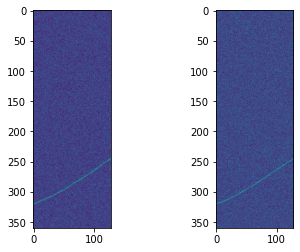

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(img[0])
ax2.imshow(img[1])

# Create SFT File

In [10]:
label = "PyFstat_example_grid_search_F0F1"
outdir = os.path.join('PyFstat_example_data', label)

writer_kwargs = {
    'label': 'single_detector_gaussian_noise',
    'outdir': 'PyFstat_example_data',
    'timestamps': {
        'H1': g['H1']['timestamps_GPS'][:],
        'L1': g['L1']['timestamps_GPS'][:]
    },
    'detectors': 'H1,L1',
    'sqrtSX': 1e-22,
    'Tsft': 1800,
    'SFTWindowType': 'tukey',
    'SFTWindowBeta': 0.01,
    'F0': (g['frequency_Hz'][0] + g['frequency_Hz'][-1]) / 2,
    'Band': 0.6,
}
writer = pyfstat.Writer(**writer_kwargs)
writer.make_data()

In [11]:
freqs, times, sft_d = pyfstat.utils.get_sft_as_arrays(writer.sftfilepath)

In [12]:
len(times['H1']), len(times['L1'])

(4600, 4571)

In [13]:
len(freqs)

1081

In [14]:
amplitudes = {k:v for k, v in sft_d.items()}

In [15]:
amplitudes['H1'].shape, amplitudes["L1"].shape

((1081, 4600), (1081, 4571))

In [16]:
img = np.empty((2, 1080, 128), dtype=np.float32)
for idx, s in enumerate(['H1', 'L1']):
    a = amplitudes[s][:1080, :4096] * 1e22

    p = a.real**2 + a.imag**2
    p /= np.mean(p)
    print(p.shape)
    p = np.mean(p.reshape(1080, 128, 32), axis=2)
    img[idx] = p

(1080, 4096)
(1080, 4096)


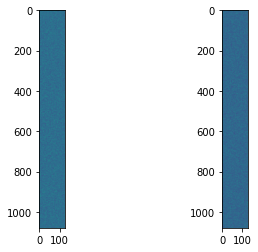

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[0])
ax2.imshow(img[1])

# Load and Write SFT Data

In [18]:
import lalpulsar

constraints = lalpulsar.SFTConstraints()
sft_catalog = lalpulsar.SFTdataFind(writer.sftfilepath, constraints)
len(sft_catalog.data)

9171

In [19]:
fMin = fMax = -1
multi_sfts = lalpulsar.LoadMultiSFTs(sft_catalog, fMin, fMax)
print(len(multi_sfts.data))
print(len(multi_sfts.data[0].data))
print(len(multi_sfts.data[0].data[0].data.data))

2
4600
1081


In [20]:
print(g["H1"]['SFTs'].shape)
print(g["L1"]['SFTs'].shape)

(360, 4600)
(360, 4571)


In [ ]:
arr = g['H1']['SFTs'][:]
for j in tqdm(np.arange(len(multi_sfts.data[0].data))):
    for k in np.arange(360):
        val = arr[k][j]
        multi_sfts.data[0].data[j].data.data[k] = val
        multi_sfts.data[0].data[j].data.data[k+360] = val
        multi_sfts.data[0].data[j].data.data[k+360*2] = val

In [28]:
import psutil
psutil.cpu_count(logical=False)
#multiprocessing.cpu_count()

1

In [29]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.210
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.42
clflush size	: 64
cache_alignment	: 64
address sizes

In [ ]:
def compute(k, j):
    val = arr[k][j]
    multi_sfts.data[0].data[j].data.data[[k, k+360, k+360*2]] = val
    return multi_sfts

In [ ]:
from queue import Queue

class Que(Queue):
    def __contains__(self, item):
        with self.mutex:
            return item in self.queue
    
    def __len__(self):
        return len(self.queue)

In [ ]:
Q = Que()
[Q.put((k, j)) for j in np.arange(len(multi_sfts.data[0].data)) for k in np.arange(360)]
arr = g['H1']['SFTs'][:]

def modify():
    while True:
        qdata = Q.get()
        k, j = qdata
        try:
            if qdata is None:
                break
            val = arr[k][j]
            multi_sfts.data[0].data[j].data.data[[k, k+360, k+360*2]] = val
        except Exception as e:
            print(f"Encountered error: {e}")
        Q.task_done()

In [ ]:
from queue import Queue
import multiprocessing

In [85]:
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
    
def square(x):
    return x**x

apply_by_multiprocessing(multi_sfts.data[0], modify, axis=1, workers=4) 

TypeError: ignored

In [ ]:
# from concurrent.futures import ThreadPoolExecutor

# def task1(j, k):
#     val = arr[k][j]
#     multi_sfts.data[0].data[j].data.data[k] = val
#     multi_sfts.data[0].data[j].data.data[k+360] = val
#     multi_sfts.data[0].data[j].data.data[k+360*2] = val
#     return multi_sfts

# def task2(j, k):
#     val = arr[k][j]
#     multi_sfts.data[1].data[j].data.data[k] = val
#     multi_sfts.data[1].data[j].data.data[k+360] = val
#     multi_sfts.data[1].data[j].data.data[k+360*2] = val
#     return multi_sfts
# for j in tqdm(np.arange(len(multi_sfts.data[0].data))):
#     for k in np.arange(360):
        
# with ThreadPoolExecutor

# arr = g['H1']['SFTs'][:]

# arr = g['L1']['SFTs'][:]

# for j in tqdm(np.arange(len(multi_sfts.data[1].data))):
#     for k in np.arange(360):
        
        
        
        

In [ ]:
!mkdir h1.sft
!mkdir l1.sft

lalpulsar.WriteSFTVector2File(multi_sfts.data[0],"h1.sft","comment","misc")
lalpulsar.WriteSFTVector2File(multi_sfts.data[1],"l1.sft","comment","misc")

In [ ]:
h1_fname = !ls h1.sft
l1_fname = !ls l1.sft

my_sftfilepath = f"h1.sft/{h1_fname[0]};l1.sft/{l1_fname[0]}"
my_sftfilepath

In [ ]:
freqs, times, sft_data = pyfstat.utils.get_sft_as_arrays(my_sftfilepath)

amplitudes = {k:v for k, v in sft_data.items()}
img = np.empty((2, 1080, 128), dtype=np.float32)
for idx, s in enumerate(['H1', 'L1']):
    a = amplitudes[s][:1080, :4096] * 1e22
    p = a.real**2 + a.imag**2
    p /= np.mean(p)
    p = np.mean(p.reshape(1080, 128, 32), axis=2)
    img[idx] = p

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[0])
ax2.imshow(img[1])

# Step 3 Matched-Filter Search

In [ ]:
def search(f0, f1, nsegs, alphas, deltas, visualize=False):
    tstart = (g['H1']['timestamps_GPS'][0] + g['L1']['timestamps_GPS'][0]) / 2
    tend = (g['H1']['timestamps_GPS'][-1] + g['L1']['timestamps_GPS'][-1]) / 2
    tref = 0.5 (tstart - tend)

    f0s = [f0]
    f1s = [f1]
    f2s = [0]

    search = pyfstat.GridSearch(
        label=label,
        outdir=outdir,
        sftfilepattern=my_sftfilepath,
        F0s=F0s,
        F1s=F1s,
        F2s=F2s,
        Alphas=alphas,
        Deltas=deltas,
        tref=tref,
        nsegs=nsegs,
        detectors="H1,L1",
    )
    search.run()

    if visualize:
        search.plot_2D(xkey='Alpha', ykey='Delta', colorbar=True)
    return np.max(search.data['twoF'])

In [ ]:
now_f0 = (g["frequency_Hz"][0] + g["frequency_Hz"][-1])/2
now_f1 = -1e-10

now_f0,now_f1

In [ ]:
alphas = [0, 2*math.pi, 2*math.pi / 100]
deltas = [-math.pi/2, math.pi/2, math.pi / 100]

search(now_f0,now_f1, 1000,alphas,deltas,True)

In [ ]:
def objective(trial):
    alphas = [0, 2*math.pi, 2*math.pi / 100]
    deltas = [-math.pi/2, math.pi/2, math.pi / 100]
    
    f0 = trial.suggest_float('f0', now_f0 - 0.1, now_f0 + 0.1)
    f1 = trial.suggest_float('f1', -4e-9, 0)
    result = search(f0,f1, 1000,alphas,deltas,False)

    return result

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout= 3 * 60 * 60)

result = study.trials_dataframe()
result.sort_values("value",ascending=False).head(10)

In [ ]:
result.sort_values("value",ascending=False).to_csv('optuna_results.csv', index=None)

In [ ]:
plt.scatter(result.params_f0, result.params_f1, c=result.value)
plt.colorbar()
plt.xlabel('f0')
plt.ylabel('f1')
plt.grid()

In [ ]:
best_f0 = study.best_params["f0"]
best_f1 = study.best_params["f1"]

best_f0,best_f1

In [ ]:
alphas = [0, 2*math.pi, 2*math.pi / 100]
deltas = [-math.pi/2, math.pi/2, math.pi / 100]
search(best_f0,best_f1, 1000,alphas,deltas,True)